In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

You should consider upgrading via the 'c:\users\maria\violence-detection\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
import os
import sys
import cv2
import zipfile
import numpy as np
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import svm
from sklearn.model_selection import train_test_split
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

In [ ]:
IMG_SIZE = 75
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 15
NUM_FEATURES = 2048

In [ ]:
def load_videos(loc, max_frames=15, resize=(IMG_SIZE, IMG_SIZE)):
    frames = []
    for video_name in os.listdir(loc):
        video = cv2.VideoCapture(os.path.join(loc,video_name))
        new_packet = []
        i = 0
        while video.isOpened():
            ret, frame = video.read()
            if not ret:
                break
            if i % 4 != 0: # Works for 30 fps videos to capture only 15 fps
                i += 1
                continue
            frame = cv2.resize(frame, resize, interpolation = cv2.INTER_AREA)
            frame = frame[:, :, [2, 1, 0]] # RGB
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            new_packet.append(frame)

            if len(new_packet) == max_frames:
                stacked = np.array(new_packet)/255.
                frames.append(stacked)
                new_packet.pop(0)
                # new_packet = np.array(new_packet)/255.
                # frames.append(new_packet)
                # new_packet = []
            i+=1
        video.release()
        if len(frames)>= 3000:
            break

    cv2.destroyAllWindows()
    frames = np.stack(frames, axis = 0)
    print(frames.shape)
    return frames # (instances_num, max_frames, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [ ]:
encoding=["Fighting", "Shooting" , "Riot", "Abuse", "CarAccident", "Explosion"]
label_processor =  keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, vocabulary=encoding
)
print(label_processor.get_vocabulary())

['', 'Fighting', 'Shooting', 'Riot', 'Abuse', 'CarAccident', 'Explosion']


In [ ]:
x_train_data = []
x_train_dir = 'D:\\ViolenceDetection\\Datasets\\XD-Violence\\Violent'
for category in os.listdir('D:\\ViolenceDetection\\Datasets\\XD-Violence\\Violent'):
    cdir = f'D:\\ViolenceDetection\\Datasets\\XD-Violence\\Violent\\{category}'
    x_train_data.append(load_videos(cdir, max_frames=15, resize= (IMG_SIZE, IMG_SIZE)))

(3010, 15, 75, 75, 3)
(3002, 15, 75, 75, 3)
(3051, 15, 75, 75, 3)
(340, 15, 75, 75, 3)
(3093, 15, 75, 75, 3)
(2664, 15, 75, 75, 3)


In [ ]:
y_train_data=[]
i = 0
for category in x_train_data:
    label=[encoding[i]] * len(category)
    y_train_data.append(label)
    i+=1

In [ ]:
[(x_train_data[i].shape, len(x_train_data[i])) for i in range(len(x_train_data))]

[((3010, 15, 75, 75, 3), 3010),
 ((3002, 15, 75, 75, 3), 3002),
 ((3051, 15, 75, 75, 3), 3051),
 ((340, 15, 75, 75, 3), 340),
 ((3093, 15, 75, 75, 3), 3093),
 ((2664, 15, 75, 75, 3), 2664)]

In [ ]:
[len(y_train_data[i]) for i in range(len(y_train_data))]

[3010, 3002, 3051, 340, 3093, 2664]

In [ ]:
x_train_data[0].shape, len(y_train_data[0])

((3010, 15, 75, 75, 3), 3010)

In [ ]:
x_train = np.concatenate(x_train_data)
y_train = np.concatenate(y_train_data)

In [ ]:
np.save('XD_Data\\XD_x_train_3000', x_train)
np.save('XD_Data\\XD_y_train_3000', y_train)

In [ ]:
del x_train_data
del y_train_data

In [ ]:
x_train = np.load('XD_Data\\XD_x_train_3000.npy')
y_train = np.load('XD_Data\\XD_y_train_3000.npy')

In [ ]:
x_train.shape , y_train.shape

((15160, 15, 75, 75, 3), (15160,))

In [ ]:
x_train, x_rem, y_train, y_rem = train_test_split(x_train, y_train,  train_size=0.7, shuffle = True, random_state=7)

In [ ]:
x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5, shuffle = True, random_state=7)

In [ ]:
np.save('XD_Data\\y_test.npy', y_test)

In [ ]:
def prepare_all(x_train, y_train):
    num_samples = len(x_train)
    labels = label_processor(y_train[..., None]).numpy()
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
          shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
      )
    for idx, packet in enumerate(x_train):
        frames = batch = packet         # (15, 75, 75, 3)
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_featutes = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )
        length = batch.shape[0]
        for j in range(length):
          temp_frame_featutes[0, j, :] = feature_extractor.predict(
                batch[None, j, :]       # (1, 100, 100, 3)
            )
        temp_frame_mask[0, :length] = 1  # 1 = not masked, 0 = masked
        frame_features[idx,] = temp_frame_featutes.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
    return (frame_features, frame_masks), labels

train_data, train_labels = prepare_all(x_train, y_train)
val_data, val_labels = prepare_all(x_valid, y_valid)
test_data, test_labels = prepare_all(x_test, y_test)
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")
print(f"Frame features in val set: {val_data[0].shape}")
print(f"Frame features in test set: {test_data[0].shape}")

Frame features in train set: (10612, 15, 2048)
Frame masks in train set: (10612, 15)
Frame features in val set: (2274, 15, 2048)
Frame features in test set: (2274, 15, 2048)


In [ ]:
np.save('XD_Data\\train_data[0]_3000.npy', train_data[0])
np.save('XD_Data\\train_data[1]_3000.npy', train_data[1])
np.save('XD_Data\\val_data[0]_3000.npy', val_data[0])
np.save('XD_Data\\val_data[1]_3000.npy', val_data[1])
np.save('XD_Data\\test_data[0]_3000.npy', test_data[0])
np.save('XD_Data\\test_data[1]_3000.npy', test_data[1])

In [ ]:
train_data = (np.load('XD_Data\\train_data[0]_3000.npy'), np.load('XD_Data\\train_data[1]_3000.npy'))
val_data = (np.load('XD_Data\\val_data[0]_3000.npy'), np.load('XD_Data\\val_data[1]_3000.npy'))
test_data = (np.load('XD_Data\\test_data[0]_3000.npy'), np.load('XD_Data\\test_data[1]_3000.npy'))
train_labels = label_processor(y_train[..., None]).numpy()
val_labels = label_processor(y_valid[..., None]).numpy()
test_labels = label_processor(y_test[..., None]).numpy()

In [ ]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(128, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(64)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam",
         metrics = ['accuracy']
    )
    return rnn_model

In [ ]:
def run_experiment():
    filepath = "C:\\Users\\Maria\\Violence-Detection\\venv\\Final_Classification\\Models\\XD_Violence_Original"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        batch_size = BATCH_SIZE,
        validation_data=([val_data[0], val_data[1]],
        val_labels),
        epochs=20,
        callbacks=[checkpoint]
    )

    seq_model.load_weights(filepath)
    loss, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history, sequence_model = run_experiment()

Epoch 1/20


UnknownError:    Fail to find the dnn implementation.
	 [[{{node cond_41/then/_0/cond/CudnnRNNV3}}]]
	 [[model/gru/PartitionedCall]] [Op:__inference_train_function_20412]

Function call stack:
train_function -> train_function -> train_function


In [ ]:
sequence_model.save("C:\\Users\\Maria\\Violence-Detection\\venv\\Final_Classification\\Models\\XD_Violence_Main_3000")

INFO:tensorflow:Assets written to: C:\Users\Maria\Violence-Detection\venv\Final_Classification\Models\XD_Violence_Main_3000\assets


INFO:tensorflow:Assets written to: C:\Users\Maria\Violence-Detection\venv\Final_Classification\Models\XD_Violence_Main_3000\assets


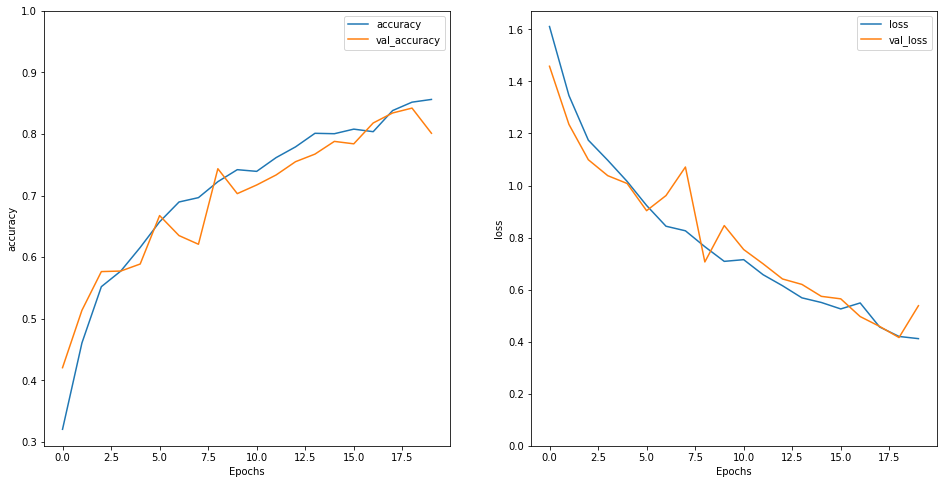

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.savefig('XD_Data\\ACC_LOSS_84.96_3000.png')


# Confusion Matrix

In [ ]:
test_pred = sequence_model.predict([test_data[0], test_data[1]])
test_pred.shape, test_pred

((2274, 7),
 array([[1.8956160e-07, 1.2608285e-02, 1.0184656e-02, ..., 2.3557210e-02,
         9.2717092e-03, 9.3806934e-01],
        [1.2613207e-08, 4.7426729e-04, 3.4724586e-03, ..., 5.3122963e-05,
         3.2764133e-06, 6.1681865e-05],
        [4.1726635e-06, 6.4608259e-03, 1.2747193e-02, ..., 2.7951002e-03,
         3.8723439e-02, 9.3123019e-01],
        ...,
        [1.2172533e-05, 2.0158687e-01, 1.1258999e-02, ..., 2.0475924e-01,
         2.4148753e-02, 4.2916393e-01],
        [4.9888621e-07, 9.9559361e-01, 1.2593514e-03, ..., 5.0534162e-04,
         1.7622342e-05, 4.9970404e-04],
        [6.8369576e-05, 4.9619633e-01, 2.4614105e-01, ..., 1.4530044e-02,
         3.4928387e-03, 6.0140230e-02]], dtype=float32))

In [ ]:
class_vocab = label_processor.get_vocabulary()
class_vocab

['', 'Fighting', 'Shooting', 'Riot', 'Abuse', 'CarAccident', 'Explosion']

In [ ]:
y_pred = []
for i in test_pred:
  for x in np.argsort(i)[::-1]:
    print(f"  {class_vocab[x]}: {i[x] * 100:5.2f}%")
    y_pred.append(class_vocab[x])
    break

  Explosion: 93.81%
  Riot: 99.59%
  Explosion: 93.12%
  Explosion: 97.59%
  Explosion: 82.01%
  Shooting: 65.02%
  Riot: 91.57%
  Shooting: 98.96%
  Fighting: 73.57%
  Riot: 99.98%
  Riot: 97.16%
  Shooting: 49.36%
  Riot: 99.08%
  Riot: 96.52%
  CarAccident: 60.90%
  Explosion: 93.15%
  Explosion: 97.15%
  CarAccident: 99.99%
  Riot: 99.50%
  Fighting: 86.30%
  Explosion: 94.77%
  Explosion: 64.86%
  Shooting: 95.69%
  Fighting: 98.69%
  Riot: 99.38%
  Shooting: 99.59%
  Explosion: 97.98%
  Riot: 99.86%
  Fighting: 85.76%
  CarAccident: 99.86%
  Fighting: 99.46%
  Shooting: 81.26%
  Fighting: 95.23%
  Explosion: 94.65%
  CarAccident: 99.99%
  CarAccident: 99.04%
  Riot: 98.91%
  CarAccident: 81.57%
  CarAccident: 69.88%
  Riot: 99.99%
  Fighting: 98.36%
  Fighting: 96.48%
  Explosion: 98.95%
  CarAccident: 99.87%
  Riot: 68.44%
  Riot: 99.99%
  Fighting: 94.40%
  Riot: 99.17%
  CarAccident: 99.98%
  Riot: 99.96%
  Fighting: 53.53%
  Fighting: 93.60%
  Fighting: 57.94%
  Shooting: 80.

  CarAccident: 97.70%
  Fighting: 94.90%
  Explosion: 86.60%
  CarAccident: 99.90%
  Fighting: 92.94%
  Explosion: 97.08%
  Explosion: 97.48%
  Explosion: 97.08%
  CarAccident: 99.56%
  Shooting: 60.23%
  Shooting: 55.55%
  Riot: 99.98%
  Riot: 54.81%
  Shooting: 45.45%
  Riot: 99.98%
  CarAccident: 99.85%
  Shooting: 93.06%
  CarAccident: 54.25%
  Explosion: 91.98%
  Riot: 98.70%
  CarAccident: 58.57%
  Fighting: 96.48%
  Shooting: 92.46%
  CarAccident: 99.90%
  Riot: 39.42%
  Fighting: 91.26%
  Explosion: 97.93%
  Riot: 82.54%
  Explosion: 78.25%
  Fighting: 90.31%
  Riot: 43.49%
  CarAccident: 99.98%
  Shooting: 36.70%
  Fighting: 67.33%
  Fighting: 98.55%
  Explosion: 89.61%
  Shooting: 85.73%
  Fighting: 99.65%
  CarAccident: 99.99%
  Fighting: 93.57%
  Explosion: 91.14%
  CarAccident: 99.89%
  Explosion: 73.74%
  CarAccident: 99.96%
  Riot: 99.95%
  Riot: 99.98%
  CarAccident: 83.16%
  Explosion: 87.83%
  Explosion: 74.23%
  Riot: 99.89%
  Riot: 63.59%
  Explosion: 55.27%
  Shoot

In [ ]:
y_pred = np.array(y_pred)
y_pred, y_pred.shape

(array(['Explosion', 'Riot', 'Explosion', ..., 'Explosion', 'Fighting',
        'Fighting'], dtype='<U11'),
 (2274,))

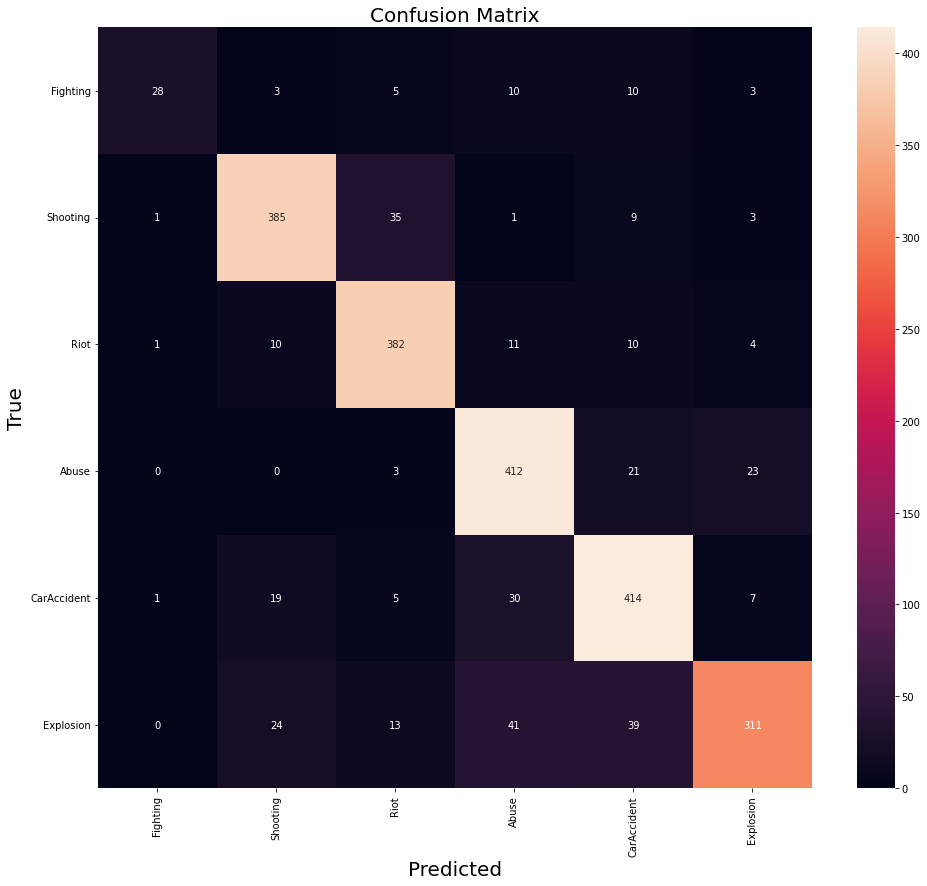

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
# cm = cm / cm.astype(np.float).sum(axis=1)

class_names = encoding

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=20)

plt.savefig('XD_Data\\ConMat84.96_3000.png')
plt.show()

# ROC

In [ ]:
plt.figure()
plt.subplot(111)
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, thresholds = roc_curve(test_labels, test_pred)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# plt.savefig("ROC_CURVE")

In [ ]:
roc_auc = roc_auc_score(test_labels, test_pred, multi_class = 'ovr')
print('Logistic ROC AUC %.3f' % roc_auc)

# Inference:


In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        print(i, batch, batch.shape)
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_featutes, frame_mask

def load_video(loc, max_frames=15, resize=(IMG_SIZE, IMG_SIZE)):
    frames = []
    video = cv2.VideoCapture(loc)
    new_packet = []
    i = 0
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        if i % 2 != 0: # Works for 30 fps videos to capture only 15 fps
            i += 1
            continue
        frame = cv2.resize(frame, resize, interpolation = cv2.INTER_AREA)
        frame = frame[:, :, [2, 1, 0]] # RGB
        new_packet.append(frame)

        if len(new_packet) == max_frames:
            new_packet = np.array(new_packet)/255.
            frames.append(new_packet)
            new_packet = []
        i+=1
    video.release()

    cv2.destroyAllWindows()
    frames = np.stack(frames, axis = 0)
    # return frames # (instances_num, max_frames, IMG_SIZE, IMG_SIZE, 3)
    return frames[16]  # (max_frames, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=5)
    return embed.embed_file("animation.gif")

In [ ]:
test_video_path = '/content/gdrive/MyDrive/DirectDownload/Anomaly-Videos-Part-4/Stealing/Stealing112_x264.mp4'
print(f"Test video path: {test_video_path}")
test_frames = sequence_prediction(test_video_path)
print(test_frames[:MAX_SEQ_LENGTH].shape. test_frames.shape)
to_gif(test_frames[:MAX_SEQ_LENGTH])